# Image Segmentation using Tensorflow

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH 

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

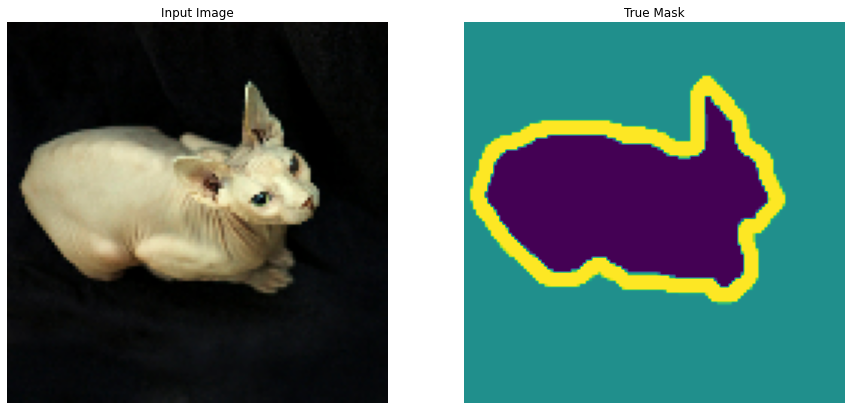

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Let's try out the model to see what it predicts before training.

In [10]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [11]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

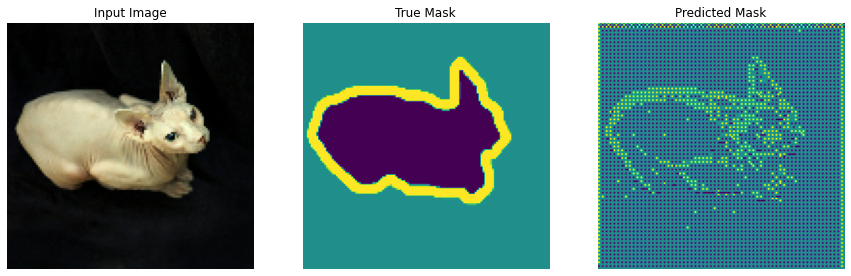

In [ ]:
show_predictions()

## Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (10, 8)) 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_dataset, 7)

**Using FDL Dataset**

In [2]:
# !pip install -q git+https://github.com/tensorflow/examples.git
# !pip install -U albumentations
# !pip uninstall opencv-python-headless==4.5.5.62 
# !pip install opencv-python-headless==4.1.2.30

from functools import partial
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Transpose, RandomRotate90  # Rotate
)
import tensorflow as tf
from tensorflow import keras
# from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

from google.colab import drive
import os
import numpy as np
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array # ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
transforms = Compose([
            RandomRotate90(p=1),
            VerticalFlip(p=0.5),
            HorizontalFlip(p=0.5),
            Transpose(p=0.5),
        ])

In [4]:
def augment_instance(image, mask):
    data = {"image": image, "mask": mask}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    return aug_img, aug_mask

In [5]:
# drive.mount('/content/drive/')
# !unzip "drive/MyDrive/fdl21-fdl-dsba.zip" -d "/content" > /dev/null
# os.listdir()

Mounted at /content/drive/


['.config',
 'train_images',
 'train.npy',
 'test_images',
 'prepare_submission.py',
 'train_masks',
 'drive',
 'sample_data']

In [3]:
# image_path = "train_images/train_images/"
# mask_path = "train_masks/train_masks/"

# print(os.listdir(image_path)[:5])
# print(os.listdir(mask_path)[:5])

['7677.jpg', '6799.jpg', '7426.jpg', '7298.jpg', '9459.jpg']
['8351.png', '6659.png', '8440.png', '7306.png', '8909.png']


In [4]:
# image_names = os.listdir(image_path)
# train_images = []
# train_masks = []
# IMG_SIZE = 512
# INPUT_SIZE = (IMG_SIZE, IMG_SIZE)

# for image_name in image_names:
#     train_image = Image.open(image_path + image_name)
#     train_image = np.array(train_image.resize(INPUT_SIZE, resample=Image.LANCZOS))
#     train_images.append(train_image)

#     mask_name = image_name.replace(".jpg", ".png")
#     train_mask = Image.open(mask_path + mask_name)
#     train_mask = np.array(train_mask.resize(INPUT_SIZE, resample=Image.NEAREST))
#     train_masks.append(train_mask)

# train_images = np.array(train_images, dtype="float")
# train_images /= 255
# train_masks = np.array(train_masks)
# train_masks = np.where(train_masks <= 24, train_masks, 0)

In [5]:
# print(train_images.shape)
# print(train_masks.shape)

(261, 512, 512, 3)
(261, 512, 512)


In [7]:
# with open('drive/MyDrive/train.npy', 'wb') as f:
#     np.save(f, train_images)
#     np.save(f, train_masks)

with open('drive/MyDrive/train.npy', 'rb') as f:
    train_images = np.load(f)
    train_masks = np.load(f)

print(train_images.shape)
print(train_masks.shape)

(261, 512, 512, 3)
(261, 512, 512)


In [24]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, x_data, y_data, batch_size):
    self.x, self.y = x_data, y_data
    self.batch_size = batch_size
    self.num_batches = np.ceil(len(x_data) / batch_size)
    self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

  def __len__(self):
    return len(self.batch_idx)

  def __getitem__(self, idx):
    batch_x = self.x[self.batch_idx[idx]]
    batch_y = self.y[self.batch_idx[idx]]
    batch_x_new = np.empty_like(batch_x)
    batch_y_new = np.empty_like(batch_y)
    for i in range(batch_x_new.shape[0]):
        image = batch_x[i, :, :, :]
        mask = batch_y[i, :, :]
        image, mask = augment_instance(image, mask)
        batch_x_new[i, :, :, :] = image
        batch_y_new[i, :, :] = mask

    return batch_x_new, batch_y_new

train_generator = DataGenerator(train_images, train_masks, batch_size=16)

In [25]:
image_batch, mask_batch = next(iter(train_generator))
print(image_batch.shape)
print(mask_batch.shape)

(16, 128, 128, 3)
(16, 128, 128)


In [26]:
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
print(first_image.shape)
print(first_mask.shape)

(128, 128, 3)
(128, 128)


In [27]:
first_mask

array([[ 0,  0,  0, ..., 19, 19, 20],
       [ 0,  0,  0, ..., 22, 22, 22],
       [ 0,  0,  0, ..., 22, 22, 22],
       ...,
       [ 0,  8, 19, ..., 22, 22, 22],
       [ 0,  7, 19, ..., 22, 22, 22],
       [ 0,  6, 17, ..., 21, 22, 22]], dtype=uint8)

In [28]:
first_image

array([[[ 14,  24,  25],
        [ 19,  30,  30],
        [ 22,  32,  36],
        ...,
        [ 70,  90, 115],
        [ 69,  88, 111],
        [ 67,  85, 107]],

       [[ 16,  26,  27],
        [ 20,  29,  30],
        [ 21,  30,  36],
        ...,
        [ 75,  94, 120],
        [ 74,  91, 117],
        [ 69,  88, 112]],

       [[ 12,  21,  23],
        [ 20,  30,  33],
        [ 31,  38,  43],
        ...,
        [ 77,  97, 124],
        [ 77,  97, 124],
        [ 74,  93, 120]],

       ...,

       [[ 13,  17,  23],
        [ 71,  78, 103],
        [113, 137, 171],
        ...,
        [ 54,  71,  86],
        [ 53,  71,  88],
        [ 53,  71,  87]],

       [[ 15,  17,  23],
        [ 68,  72,  97],
        [118, 141, 175],
        ...,
        [ 54,  70,  86],
        [ 53,  70,  86],
        [ 53,  70,  85]],

       [[ 13,  19,  22],
        [ 59,  63,  85],
        [118, 140, 174],
        ...,
        [ 53,  71,  86],
        [ 53,  70,  84],
        [ 52,  69,  85]]

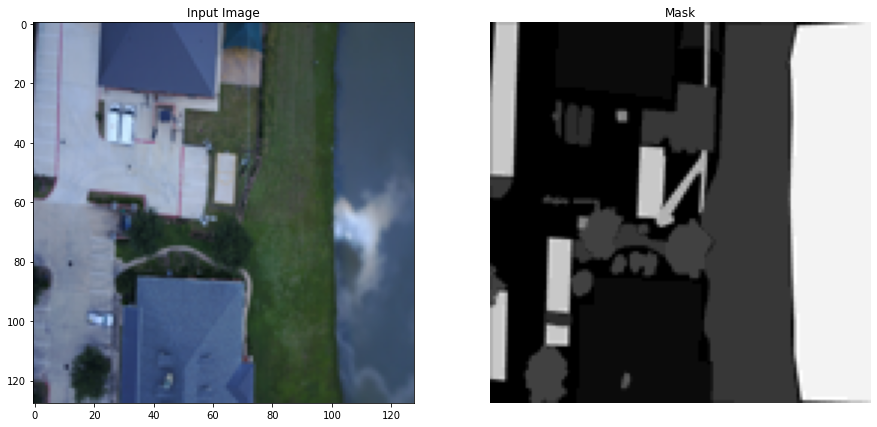

In [31]:
def draw_image_mask(image, mask):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis('off')
    plt.show()

draw_image_mask(first_image, first_mask)

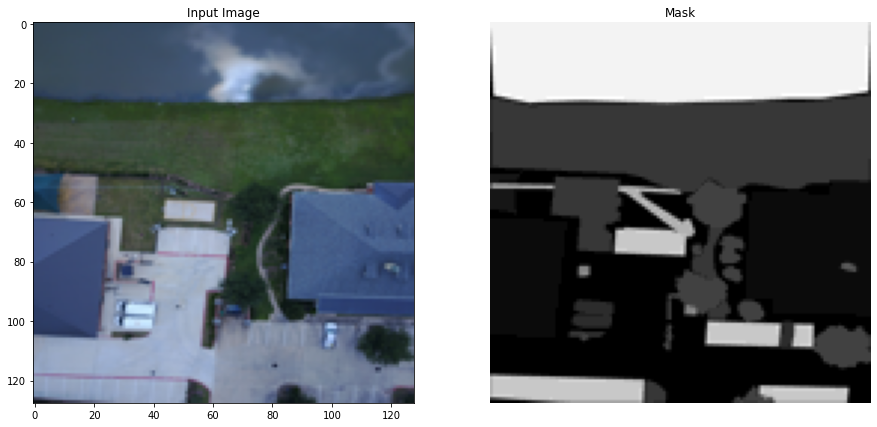

In [32]:
image_batch, mask_batch = next(iter(train_generator))
first_image = image_batch[0, :, :, :]
first_mask = mask_batch[0, :, :]
draw_image_mask(first_image, first_mask)

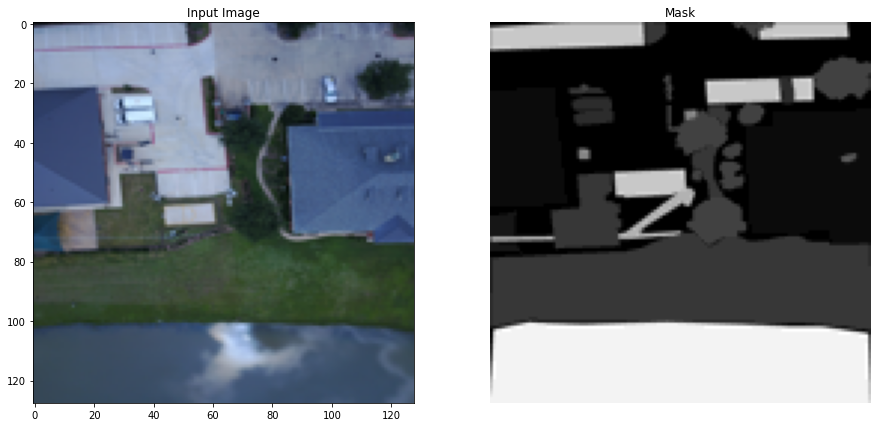

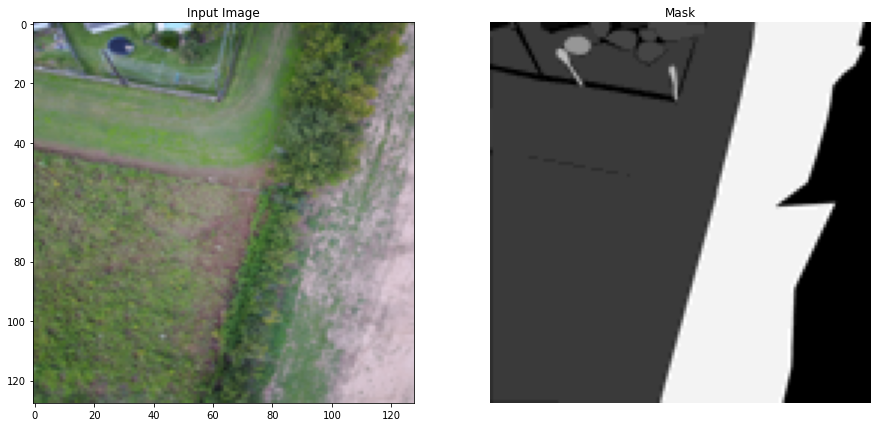

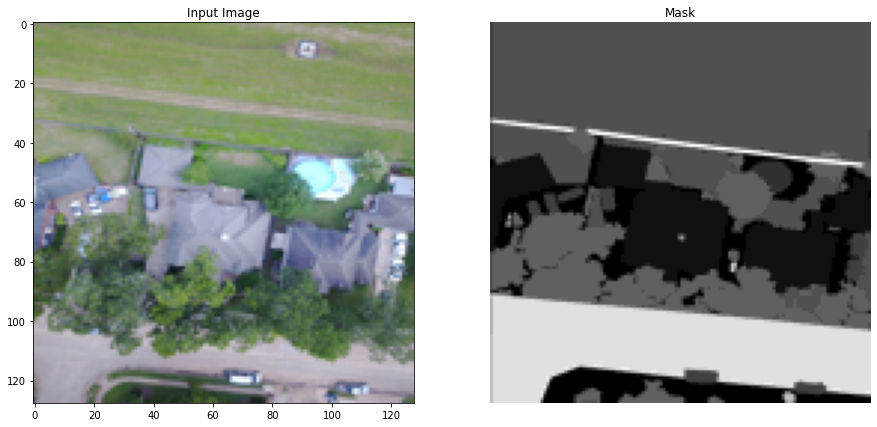

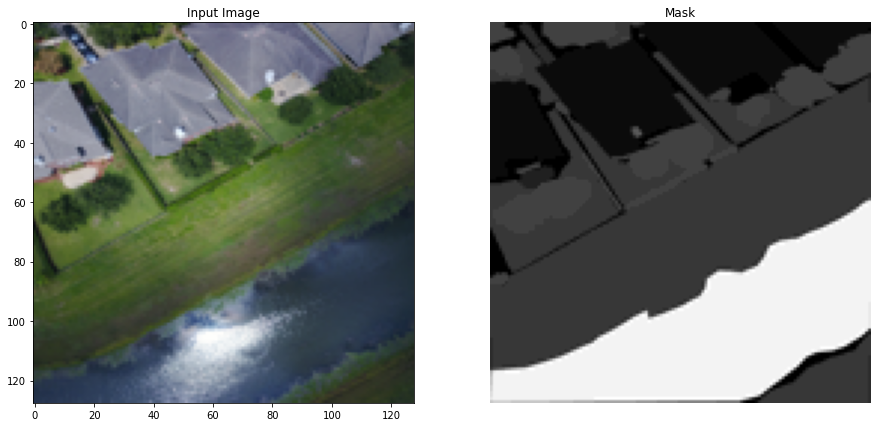

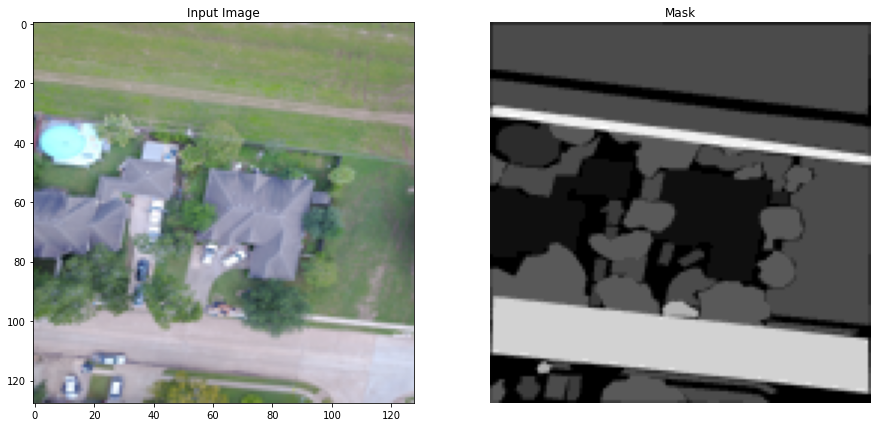

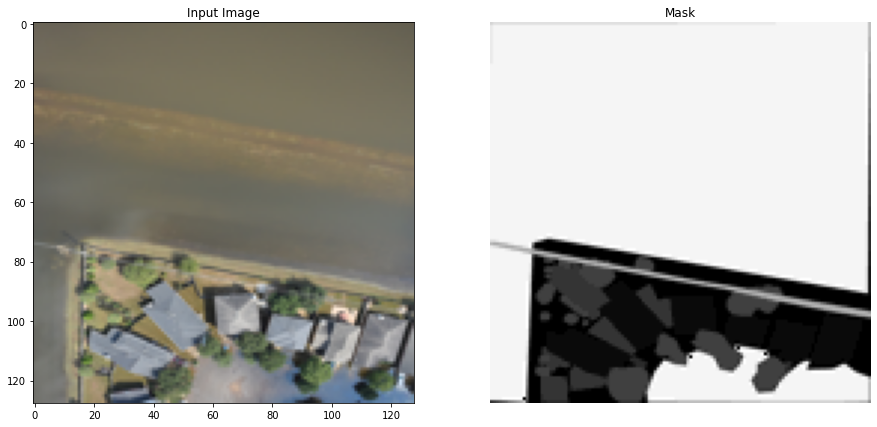

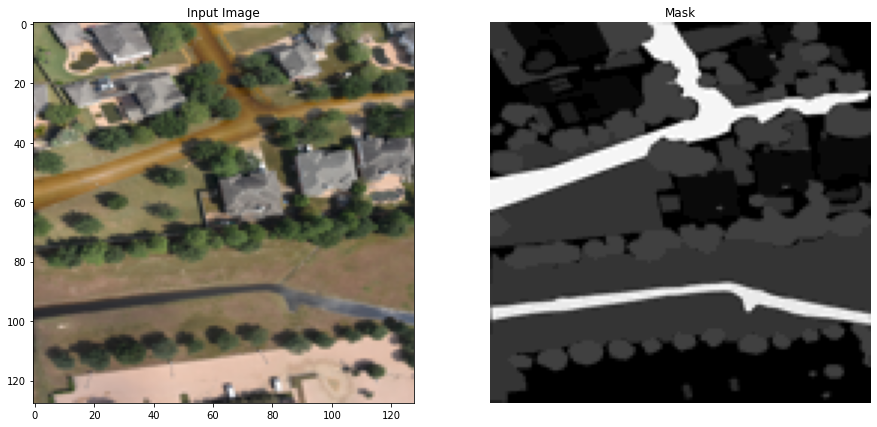

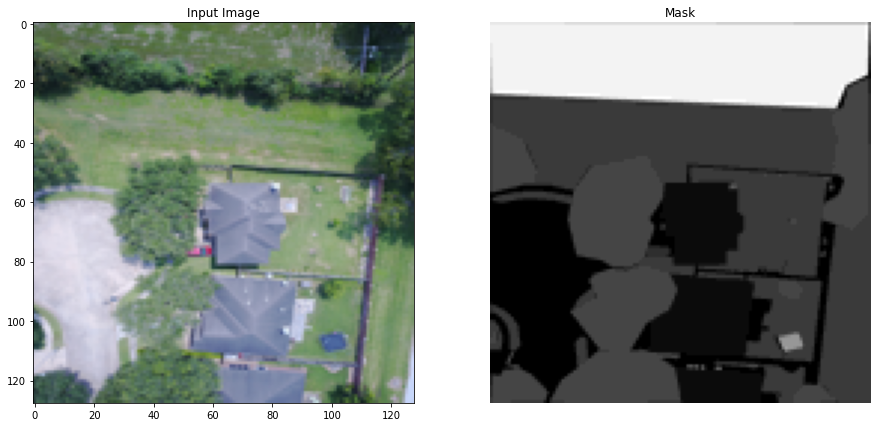

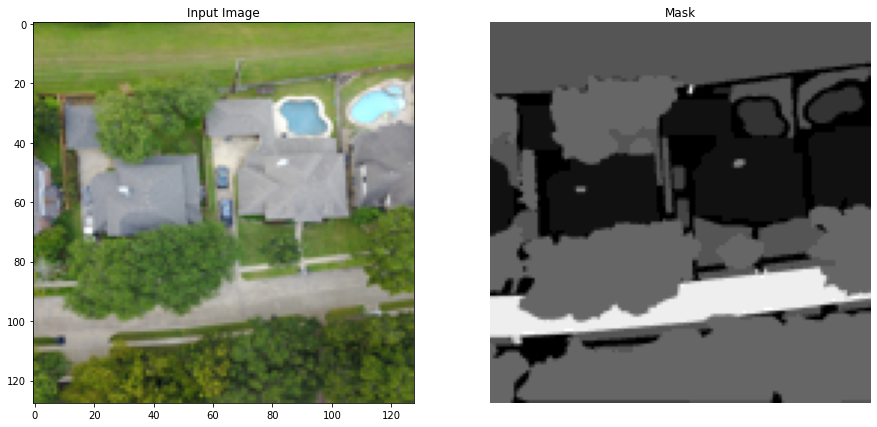

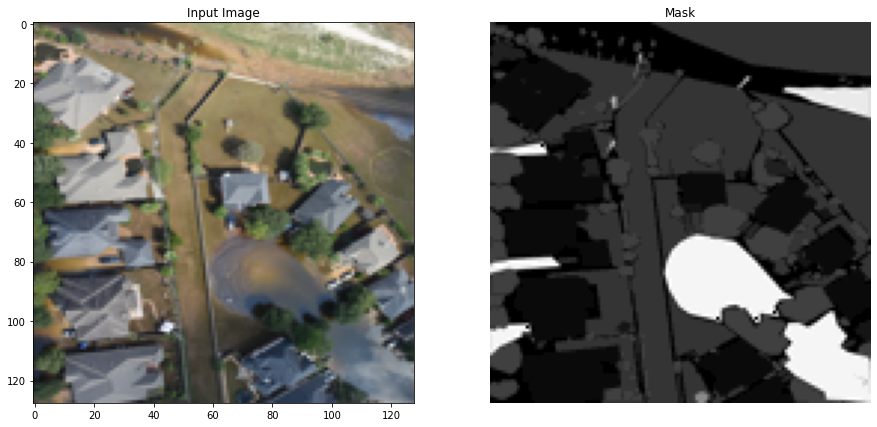

In [33]:
for i in range(10):
    current_image = train_images[i]
    current_mask = train_masks[i]
    draw_image_mask(current_image, current_mask)

In [34]:
print(np.unique(train_masks))
print("number of classes is", len(np.unique(train_masks)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
number of classes is 25


In [61]:
model = unet_model(25)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

EPOCHS = 20
VAL_SUBSPLITS = 5
# VALIDATION_STEPS = info.splits['test'].num_examples
model_history = model.fit(train_generator, 
                          epochs=EPOCHS),
                          # steps_per_epoch=STEPS_PER_EPOCH)
                          # validation_split=0.2)
                          # validation_steps=VALIDATION_STEPS,
                          # validation_data=test_dataset,
                          # callbacks=[DisplayCallback()])

Epoch 1/20
17/17 [==============================] - 6s 134ms/step - loss: 5.1516 - accuracy: 0.1036
Epoch 2/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5941 - accuracy: 0.1355
Epoch 3/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5749 - accuracy: 0.1396
Epoch 4/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5598 - accuracy: 0.1402
Epoch 5/20
17/17 [==============================] - 2s 124ms/step - loss: 3.5538 - accuracy: 0.1399
Epoch 6/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5676 - accuracy: 0.1408
Epoch 7/20
17/17 [==============================] - 2s 122ms/step - loss: 3.5726 - accuracy: 0.1398
Epoch 8/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5764 - accuracy: 0.1378
Epoch 9/20
17/17 [==============================] - 2s 123ms/step - loss: 3.5822 - accuracy: 0.1377
Epoch 10/20
17/17 [==============================] - 2s 124ms/step - loss: 3.5742 - accuracy: 0.1372

In [48]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure(figsize = (10, 8)) 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

AttributeError: ignored

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import glob         # file operations
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image # Image I/O (e.g. Image.open)
import matplotlib.pyplot as plt

In [ ]:
# Input data files are available in the read-only "../input/" directory
train_images = '../input/fdl2022/train_images/train_images/'
train_masks = '../input/fdl2022/train_masks/train_masks/'
test_image = '../input/fdl2022/test_images/test_images/'

In [ ]:
# Get the directories of all images and masks
train_x = sorted(glob.glob(train_images+'*.jpg'))
train_y = sorted(glob.glob(train_masks+'*.png'))
test_x = glob.glob(test_image+'*.jpg')

print('Train Images:', len(train_x))
print('Test Images:', len(test_x))

In [ ]:
# Randomly select and image/mask pair from the training set
idx = np.random.choice(range(len(train_x)))
img = Image.open(train_x[idx])
msk = Image.open(train_y[idx])

print('Image Size:',img.size)
print('Mask Size:',msk.size)

# Show the image
plt.imshow(img.resize((512,512)))
plt.imshow(msk.resize((512,512)), alpha=0.5)
plt.show()

In [ ]:
builder = tfds.ImageFolder('../input/fdl2022/')
print(builder.info)  # num examples, labels... are automatically calculated
train_images = builder.as_dataset(split='train_images', shuffle_files=False)
tfds.show_examples(train_images, builder.info)

train_masks = builder.as_dataset(split='train_masks', shuffle_files=False)
tfds.show_examples(train_masks, builder.info)

test_images = builder.as_dataset(split='test_images', shuffle_files=False)
tfds.show_examples(test_images, builder.info)

In [ ]:
train_masks

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples

model_history = model.fit(train_masks, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          #validation_steps=VALIDATION_STEPS,
                          validation_data=test_images,
                          callbacks=[DisplayCallback()])